In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections

import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import norm

from statsmodels import stats
import statsmodels

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

import tensorflow as tf
print('This code requires TensorFlow v1.3+')
print('You have:', tf.__version__)

%matplotlib inline

This code requires TensorFlow v1.3+
You have: 1.4.0


In [3]:
# https://github.com/tensorflow/workshops/blob/master/notebooks/07_structured_data.ipynb
# https://archive.ics.uci.edu/ml/datasets/adult

Objective: Try to improve upon "07 structured data" ~75% result for a linear classifier.

Steps taken:
    1. Convert target to boolean, whether or not income above 50k.
    2. Removed capital gains and capital losses from data set.
    3. Normalized numerical data.
    4. Checked for skewed data and applied log transformation to fnlwgt.
    5. Checked for correlations between independent input features.
    6. Created some new features.
    
Todo:
    1. Check if the categorization of input features make sense. (Can we identify better groupings?) WIP
    2. Find better way to address nan data.
    

Results:
    1. Achieved 83.8% accuracy thus far on first pass. 12/09/2017

In [4]:
census_train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
census_test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
census_train_path = tf.contrib.keras.utils.get_file('census.train', census_train_url)
census_test_path = tf.contrib.keras.utils.get_file('census.test', census_test_url)

In [5]:
column_names = [
  'age', 'workclass', 'fnlwgt', 'education', 'education-num',
  'marital-status', 'occupation', 'relationship', 'race', 'gender',
  'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
  'income'
]

In [6]:
# Notes
# 1) We provide the header from above.
# 2) The test file has a line we want to disgard at the top, so we include the parameter 'skiprows=1'
census_train = pd.read_csv(census_train_path, index_col=False, names=column_names) 
census_test = pd.read_csv(census_test_path, skiprows=1, index_col=False, names=column_names)

# Drop any rows that have missing elements
# Of course there are other ways to handle missing data, but we'll
# take the simplest approach here.
census_train = census_train.dropna(how="any", axis=0)
census_test = census_test.dropna(how="any", axis=0)

In [7]:
# Separate the label we want to predict into its own object 
# At the same time, we'll convert it into true/false to fix the formatting error

census_train_label = census_train.pop('income').apply(lambda x: ">50K" in x)
census_test_label = census_test.pop('income').apply(lambda x: ">50K" in x)

In [8]:
print ("Training examples: %d" % census_train.shape[0])
print ("Training labels: %d" % census_train_label.shape[0])
print()
print ("Test examples: %d" % census_test.shape[0])
print ("Test labels: %d" % census_test_label.shape[0])

Training examples: 32561
Training labels: 32561

Test examples: 16281
Test labels: 16281


In [9]:
census_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [10]:
census_train_label.head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7     True
8     True
9     True
Name: income, dtype: bool

### Input functions for training and data

In [11]:
# Separate for train and test so that we can tailor each accordingly.
def create_train_input_fn(): 
    return tf.estimator.inputs.pandas_input_fn(
        x=census_train,
        y=census_train_label, 
        batch_size=128,
        num_epochs=None, # Repeat forever
        shuffle=True)

def create_test_input_fn():
    return tf.estimator.inputs.pandas_input_fn(
        x=census_test,
        y=census_test_label, 
        num_epochs=1, # Just one epoch
        shuffle=False) # Don't shuffle so we can compare to census_test_labels later

## Pre-process and Train Linear Model

In [12]:
print(census_train.columns)
print("# of original features: {}".format(census_train.columns.size))

Index([u'age', u'workclass', u'fnlwgt', u'education', u'education-num',
       u'marital-status', u'occupation', u'relationship', u'race', u'gender',
       u'capital-gain', u'capital-loss', u'hours-per-week', u'native-country'],
      dtype='object')
# of original features: 14


A considerable number of more instances of False.

Just guessing False will result in a accuracy of 0.759190442554


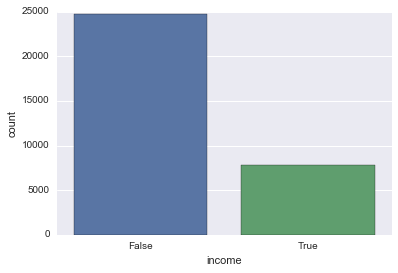

In [13]:
# Properties of target variable
target = census_train_label
target.head()
sns.countplot(target)
false = target[target==False].count()
print("Just guessing False will result in a accuracy of {}".format(false/target.count()))

### Reconsider feature grouping

#### Split between numeric and non-numeric

In [14]:
# Split between numeric and non-numeric
numeric = []
non_numeric = []
for col in census_train.columns:
    print(col+":\t", census_train[col].dtypes)
    if census_train[col].dtypes == 'int64':
        numeric.append(col)
    else:
        non_numeric.append(col)
        
# Split between low and high dimensional
# Lets say that less than 15 is low dimensional
low_dim = []
high_dim =[]

for feature in non_numeric:
    unique = len(census_train[feature].unique())
    if unique < 20:
        low_dim.append((feature,unique))
    else:
        high_dim.append((feature,unique))

print("Low dim non-numeric features: {}".format(low_dim))
print("High dim non-numeric features: {}".format(high_dim))

age:	 int64
workclass:	 object
fnlwgt:	 int64
education:	 object
education-num:	 int64
marital-status:	 object
occupation:	 object
relationship:	 object
race:	 object
gender:	 object
capital-gain:	 int64
capital-loss:	 int64
hours-per-week:	 int64
native-country:	 object
Low dim non-numeric features: [('workclass', 9), ('education', 16), ('marital-status', 7), ('occupation', 15), ('relationship', 6), ('race', 5), ('gender', 2)]
High dim non-numeric features: [('native-country', 42)]


In [24]:
census_train["education"].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [83]:
preschool = [' Preschool']
elementary = [' 1st-4th',' 5th-6th']
junior = [' 7th-8th']
highschool = [' 9th', ' 10th', ' 11th',  ' 12th', ' HS-grad',' Assoc-acdm', ' Assoc-voc']
undergrad = [' Some-college', ' Bachelors']
profschool = [' Prof-school']
master =[' Masters']
doctor = [' Doctorate']


We can visually see that higher education results in a larger set of samples where income is greater than 50k, which is consistent with general a priori perceptions.

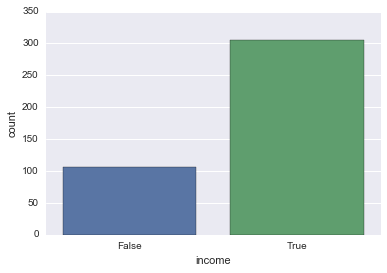

In [84]:
sns.countplot(census_train_label.iloc[np.where(census_train['education']==" Doctorate")])

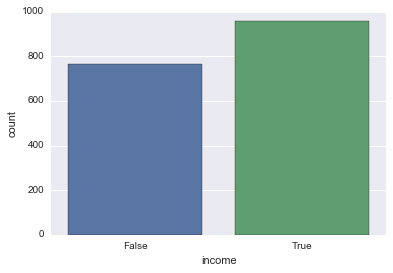

In [85]:
sns.countplot(census_train_label.iloc[np.where(census_train['education']==" Masters")])

### Find skewed data

#### Create plots to visualize the distribution of the numerical data

In [14]:
numeric

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

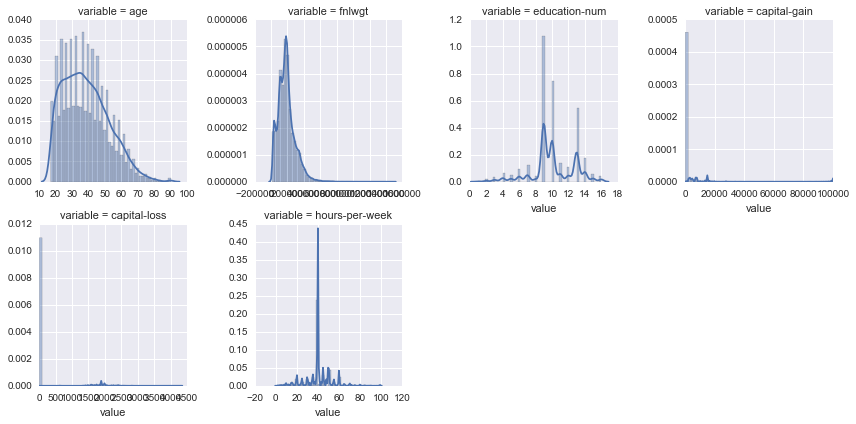

In [15]:
nd = pd.melt(census_train, value_vars = numeric)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

Jarque_bera test for normality really doesnt provide us much...basically indicates none of the features are normally distributed.


In [16]:
for feature in numeric:
    print(feature+":\t", sp.stats.jarque_bera(census_train[feature]))

age:	 (1731.584024439665, 0.0)
fnlwgt:	 (63810.981074231931, 0.0)
education-num:	 (1053.9792970305425, 0.0)
capital-gain:	 (33275952.272481531, 0.0)
capital-loss:	 (677694.43107165361, 0.0)
hours-per-week:	 (11817.798208394232, 0.0)


In [17]:
# Use rule of thumb if absolute value of skew is larger than 0.5
# then considered skewed.

for feature in numeric:
    skew = sp.stats.skew(census_train[feature])
    abs_skew = np.abs(skew)
    skewed = lambda x: "skewed" if x > 0.5 else ""
    print(feature+":\t", skew, skewed(abs_skew) )

age:	 0.55871762924 skewed
fnlwgt:	 1.44691343514 skewed
education-num:	 -0.311661509635 
capital-gain:	 11.9532969982 skewed
capital-loss:	 4.59441745644 skewed
hours-per-week:	 0.227632049775 


Age, fnlwgt, capital-gain, capital-loss can be considered as skewed...

In [18]:
# capital-gain and capital-loss
capgain = census_train['capital-gain']
caploss = census_train['capital-loss']
print("% of sample with capgains {}".format(capgain[capgain>0].count()/capgain.count()*100.))
print("% of sample with caploss {}".format(caploss[caploss>0].count()/caploss.count()*100.))

% of sample with capgains 8.32898252511
% of sample with caploss 4.66509013851


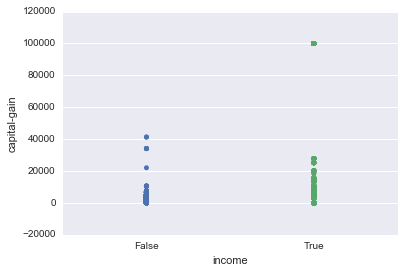

In [19]:
sns.stripplot(y=census_train['capital-gain'], x= census_train_label)

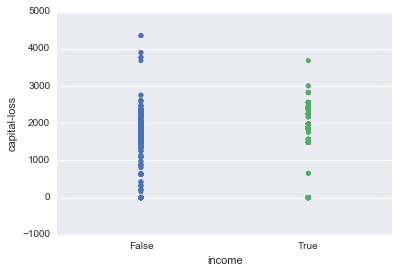

In [20]:
sns.stripplot(y=census_train['capital-loss'], x= census_train_label)

In [21]:
# Both cap gains and cap loss are sparse data sets, and visually offer no real insight with respect
# to having an income greater than 50k. Lets see what happens if we remove these two features.

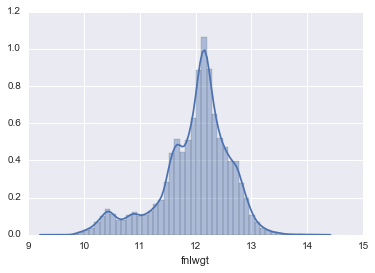

In [22]:
# Add the log transformation of fnlwgt
fnlwgt = census_train['fnlwgt']
sns.distplot(np.log(fnlwgt))

In [23]:
census_train['fnlwgt_log'] = np.log(census_train['fnlwgt'])
census_test['fnlwgt_log'] = np.log(census_test['fnlwgt'])

### Check for high correlation between features

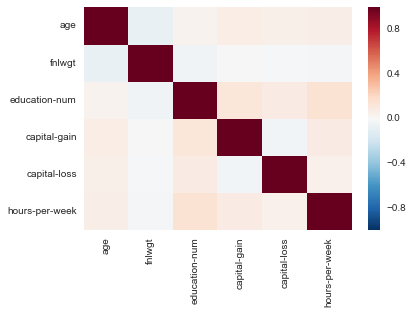

In [24]:
corr = census_train[numeric].corr()
sns.heatmap(corr)

### Normalize Numerical Data

In [25]:
def normalize(col):
    return (col - np.mean(col)) / np.std(col)

# normalize numerical features
census_train["age"] = normalize(census_train["age"].values)
census_train["education-num"] = normalize(census_train["education-num"].values)
census_train["hours-per-week"] = normalize(census_train["hours-per-week"].values)
census_train["fnlwgt_log"] = normalize(census_train["fnlwgt_log"].values)

census_test["age"] = normalize(census_test["age"].values)
census_test["education-num"] = normalize(census_test["education-num"].values)
census_test["hours-per-week"] = normalize(census_test["hours-per-week"].values)
census_test["fnlwgt_log"] = normalize(census_test["fnlwgt_log"].values)

# delete unused columns
del census_train["fnlwgt"]
del census_train["capital-gain"]
del census_train["capital-loss"]
del census_test["fnlwgt"]
del census_test["capital-gain"]
del census_test["capital-loss"]


In [26]:
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    low_dim[0][0], census_train[low_dim[0][0]].unique())

education = tf.feature_column.categorical_column_with_vocabulary_list(
    low_dim[1][0], census_train[low_dim[1][0]].unique())

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    low_dim[2][0], census_train[low_dim[2][0]].unique())

occupation = tf.feature_column.categorical_column_with_vocabulary_list(
    low_dim[3][0], census_train[low_dim[3][0]].unique())

relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    low_dim[4][0], census_train[low_dim[4][0]].unique())
     
race = tf.feature_column.categorical_column_with_vocabulary_list(
    low_dim[5][0], census_train[low_dim[5][0]].unique())

gender = tf.feature_column.categorical_column_with_vocabulary_list(
    low_dim[6][0], census_train[low_dim[6][0]].unique())
     

### Create New Features

In [27]:
age_buckets = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('age'), 
    boundaries=list(range(10)) # specify the ranges
)

In [28]:
feature_columns = [
    # Use indicator columns for low dimensional vocabularies
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(marital_status),
    tf.feature_column.indicator_column(occupation),
    tf.feature_column.indicator_column(relationship),
    tf.feature_column.indicator_column(race),
    tf.feature_column.indicator_column(gender),
    tf.feature_column.indicator_column(age_buckets),
    
    tf.feature_column.embedding_column(  # now using embedding!
        # params are hash buckets, embedding size
        tf.feature_column.categorical_column_with_hash_bucket('native-country', 1000), 10),
    
    tf.feature_column.embedding_column(
        tf.feature_column.crossed_column(
            [age_buckets, education],
            hash_bucket_size=int(1e4)
        ),
        dimension=10
    ),
        
    # numeric features
    tf.feature_column.numeric_column('age'),
    tf.feature_column.numeric_column('fnlwgt_log'),
    tf.feature_column.numeric_column('education-num'),
    tf.feature_column.numeric_column('hours-per-week'),   
]

### Define estimator as a linear classifier

In [29]:
estimator = tf.estimator.LinearClassifier(optimizer=tf.train.FtrlOptimizer(
                                    learning_rate=0.1,
                                    l1_regularization_strength=1.0,
                                    l2_regularization_strength=1.0),
                                    feature_columns=feature_columns, 
                                    n_classes=2,
                                    model_dir='graphs/linear')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efce0aacd10>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'graphs/linear', '_save_summary_steps': 100}


### Train

In [30]:
train_input_fn = create_train_input_fn()
estimator.train(train_input_fn, steps=5000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from graphs/linear/model.ckpt-10000
INFO:tensorflow:Saving checkpoints for 10001 into graphs/linear/model.ckpt.
INFO:tensorflow:loss = 50.096, step = 10001
INFO:tensorflow:global_step/sec: 113.497
INFO:tensorflow:loss = 42.9063, step = 10101 (0.885 sec)
INFO:tensorflow:global_step/sec: 153.315
INFO:tensorflow:loss = 42.8782, step = 10201 (0.650 sec)
INFO:tensorflow:global_step/sec: 148.988
INFO:tensorflow:loss = 50.5404, step = 10301 (0.672 sec)
INFO:tensorflow:global_step/sec: 86.8219
INFO:tensorflow:loss = 40.8111, step = 10401 (1.154 sec)
INFO:tensorflow:global_step/sec: 116.134
INFO:tensorflow:loss = 48.1555, step = 10501 (0.863 sec)
INFO:tensorflow:global_step/sec: 122.352
INFO:tensorflow:loss = 41.2387, step = 10601 (0.815 sec)
INFO:tensorflow:global_step/sec: 131.867
INFO:tensorflow:loss = 46.6556, step = 10701 (0.759 sec)
INFO:tensorflow:global_step/sec: 116.931
INFO:tensorflow:loss = 37.4594, step

### Evaluate

In [31]:
test_input_fn = create_test_input_fn()
estimator.evaluate(test_input_fn)

INFO:tensorflow:Starting evaluation at 2017-12-09-13:12:59
INFO:tensorflow:Restoring parameters from graphs/linear/model.ckpt-15000
INFO:tensorflow:Finished evaluation at 2017-12-09-13:13:01
INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.837664, accuracy_baseline = 0.763774, auc = 0.887553, auc_precision_recall = 0.698605, average_loss = 0.346929, global_step = 15000, label/mean = 0.236226, loss = 44.1278, prediction/mean = 0.241785


{'accuracy': 0.83766353,
 'accuracy_baseline': 0.76377374,
 'auc': 0.88755333,
 'auc_precision_recall': 0.69860518,
 'average_loss': 0.34692934,
 'global_step': 15000,
 'label/mean': 0.23622628,
 'loss': 44.127785,
 'prediction/mean': 0.24178456}